# H-NMR Spectroscopy Analysis

## Introduction

This notebook contains my analysis of a dataset of 750 molecules, each described by 471 numerical features derived from Hydrogen-NMR (H-NMR) spectroscopy, which I use to build and compare models to predict the permeability endpoint `Perm_B_A`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

# Load the CSV
df = pd.read_csv("UTF-8NMR_permeability_mol_data.csv")
# Quick look and verification of successful load.
print(df.head())
print(df.shape)
df.isnull().values.any() # Check for any missing values. 

  Mol_ID  Perm_B_A_ratio  Perm_B_A  feature_1  feature_2  feature_3  \
0  cpd_1            0.67     39.91   2.385560   2.373710   2.409160   
1  cpd_2            0.74     27.84   0.978524   0.949032   0.960871   
2  cpd_3            0.90     35.77   4.345680   4.081390   4.506200   
3  cpd_4            0.77     55.70   0.624887   0.636147   0.590279   
4  cpd_5            0.84     26.12   0.840767   0.824015   0.839137   

   feature_4  feature_5  feature_6  feature_7  ...  feature_462  feature_463  \
0   2.446300   2.499800   2.378140   2.466660  ...     1.859710     1.864410   
1   0.952576   0.999058   0.984649   0.958576  ...     0.488225     0.452507   
2   4.317350   4.236300   4.421630   4.258620  ...     2.927000     2.867170   
3   0.632796   0.636375   0.652339   0.639400  ...     0.544775     0.516020   
4   0.807039   0.853225   0.848529   0.858578  ...     0.457139     0.422131   

   feature_464  feature_465  feature_466  feature_467  feature_468  \
0     1.877000     1.8

np.False_

## Exploratory Data Analysis

### Choosing the permeability endpoint
There are two possible variables to predict. Which one should I choose? Let's do a quick exploratory analysis of each.

First, let's look at the distribution of each. 

From these histograms, I can see a massive right skew in the ratio column, as we might expect given the experiment setup.
For most supervised learning models, this could definitely cause issues. As a result, it will probably be easier to work with the the other column. 

0.29957367668223583


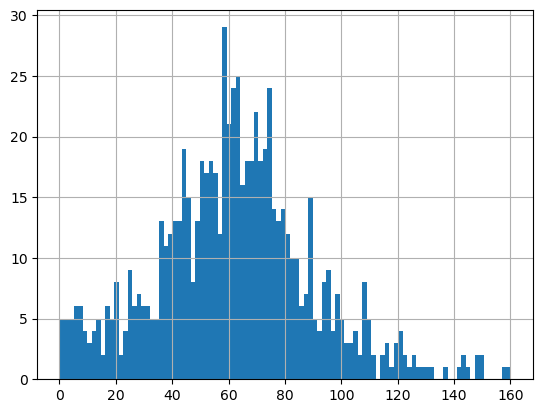

In [2]:
df["Perm_B_A"].hist(bins = 100)
print(scipy.stats.skew(df["Perm_B_A"]))

<Axes: >

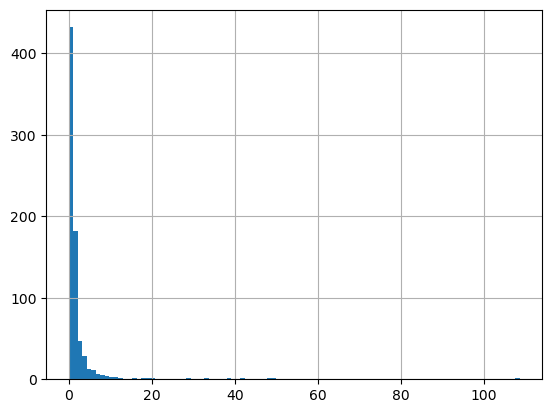

In [3]:
df["Perm_B_A_ratio"].hist(bins=100)

### Analyzing the features
Next, let's take a look at the input features. First, I noticed that there are 471 features while there are 750 total samples. In other words, we have a high dimensional low sample size problem (HDLSS).
This will prove challenging for machine learning (e.g. curse of dimensionality). To mitigate this, let's investigate the input features more closely. 


<Axes: >

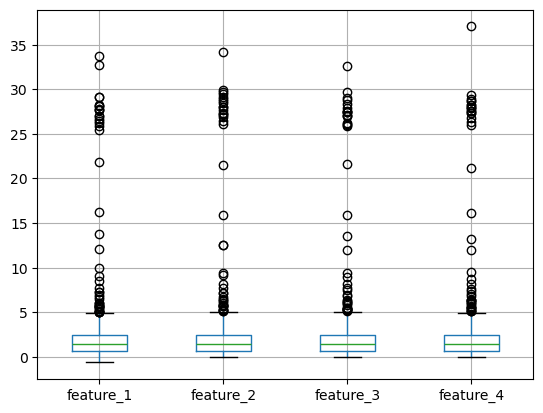

In [4]:
X = df.drop(columns=['Mol_ID', 'Perm_B_A_ratio', 'Perm_B_A'])
Y = df['Perm_B_A']

X[["feature_1", "feature_2", "feature_3", "feature_4"]].boxplot()

<Axes: >

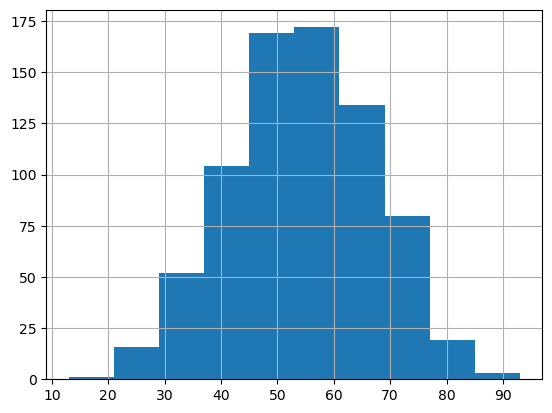

In [5]:
# Count the number of outliers
# Code from https://stackoverflow.com/a/73564418

X.iloc[:,:-1].apply(lambda r: (r < (r.quantile(0.25) - 1.5*scipy.stats.iqr(r))) | ( r > (r.quantile(0.75) + 1.5*scipy.stats.iqr(r))) , axis=1).sum(axis = 1).hist()

It's clear from this analysis that each sample has many outliers in their features. As a result, it will not be suitable to simply remove samples with outliers. I will address this during the model design in various iterations. 

### Features Preprocessing
To begin to mitigate the extreme values in the input features, we use the RobustScaler from sklearn to scale our data.
In addition, to address the HDLSS problem mentioned earlier, we can analyze whether PCA could be applied in this dataset by looking at the correlation matrix and an elbow plot. 

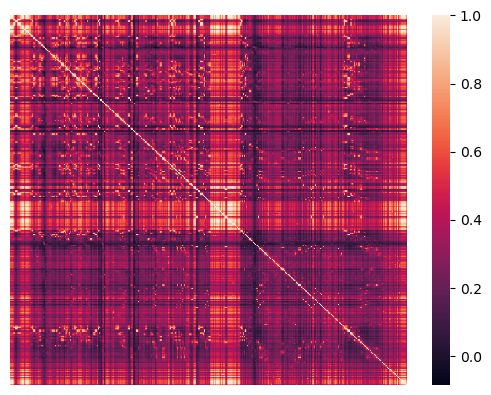

In [6]:
import seaborn as sns
correlations = X.corr(method="pearson")
sns.heatmap(correlations, xticklabels = False, yticklabels = False)
plt.show()

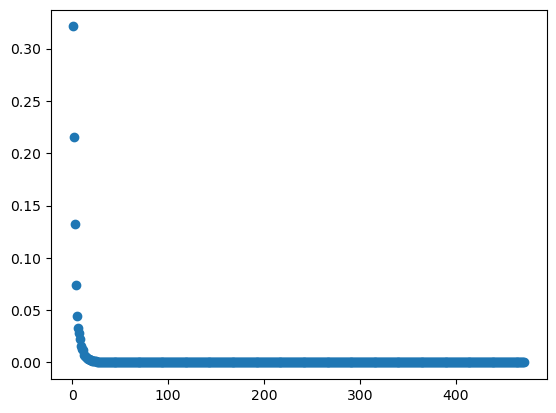

In [7]:
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

scaler = RobustScaler()
pca = PCA()
pca.fit(scaler.fit_transform(X))

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o')

The Pearson correlation heatmap shows that many of the variables are linearly correlated 
The elbow plot confirms that only a few components capture most of the variance in the dataset.

Altogether, these are strong indicators that PCA would be helpful in this experiment. 


## Model Design
Let's begin the setup for the model design. I split the dataset into input/output then into training/testing. I am using a test size of 10% here, because the dataset is already quite small. 
In practice, I would decide this number based on the experimental setup. For example, we may have a separate testing dataset that could be collected later as part of wet lab experiments, so this test dataset is more of a validation dataset.

Because the output has relatively low skew, I believe a simple random split is sufficient as opposed to more sophisticated methods such as stratification.

### Model Selection
I will train three models and compare their performances. The models chosen are ElasticNet, SVR, and Random Forest. 
- [ElasticNet](https://en.wikipedia.org/wiki/Elastic_net_regularization): a generalization of the linear support vector machine which combines two regularizations and helps with collinear features.
- [SVR](https://www.mathworks.com/help/stats/understanding-support-vector-machine-regression.html): Using an RBF kernel, we can hopefully capture non-linearity.
- [Random Forest](https://en.wikipedia.org/wiki/Random_forest): More robust to outliers

### Model Training
To facilitate the training of multiple models to include the same preprocessing steps on the training data, I will construct sklearn pipelines. 

In [8]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
print(x_test.shape) # Ensure the split worked

pipelines = {
    'ElasticNet': Pipeline(
    [
        ('scaling', RobustScaler()),
        ('reduce_dim', PCA(n_components = 0.95)),
        ('model', ElasticNet(alpha = 0.1, random_state=42))
    ]),
    'SVR': Pipeline(
    [
        ('scaling', RobustScaler()),
        ('reduce_dim', PCA(n_components = 0.95)),
        ('model', SVR(kernel='rbf'))
    ]),
    'Random Forest': Pipeline(
    [
        # RF should be robust to outliers and not require scaling. 
        ('model', RandomForestRegressor(random_state=42))
    ])
}

(75, 471)


## Evaluating the models
In this experimental setup, we are doing a regression analysis, so we will use Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and $R^2$ as metrics. 

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def train_evaluate_model(pipeline, x_train, y_train, x_test, y_test):
    pipeline.fit(x_train, y_train) # Train model
    y_pred = pipeline.predict(x_test) # Get predictions
    residuals = y_test - y_pred 
    # Plot residuals
    plt.scatter(y_pred, residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title("Residual Plot")
    plt.figure()
    plt.figure()
    plt.scatter(y_test, y_pred, c='crimson')
    # Make scatterplot 
    p1 = max(max(y_pred), max(y_test))
    p2 = min(min(y_pred), min(y_test))
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.show()
    return {
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R2": r2_score(y_test, y_pred)
    }

## Results
We can do a quick first iteration of the pipelines as defined above. This should give us a sense of how the models are doing at base levels. 

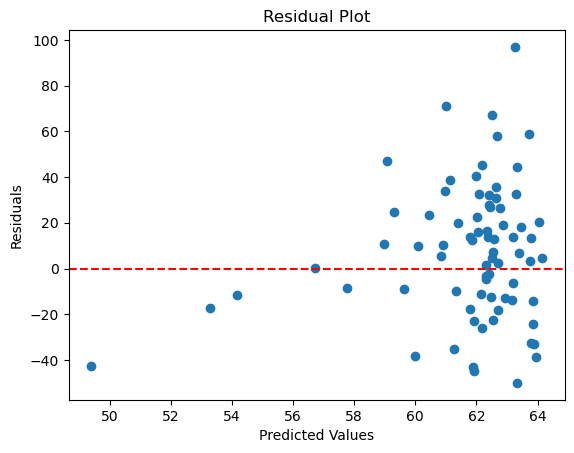

<Figure size 640x480 with 0 Axes>

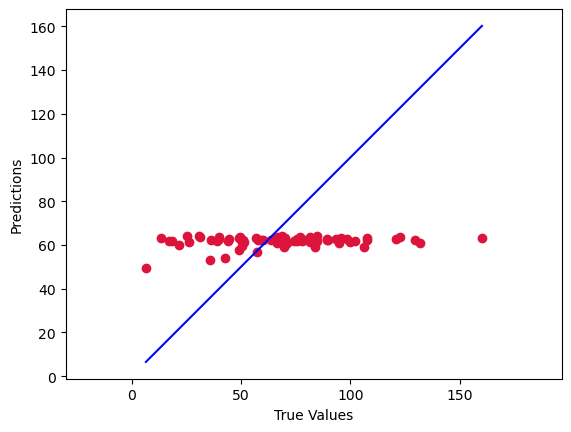

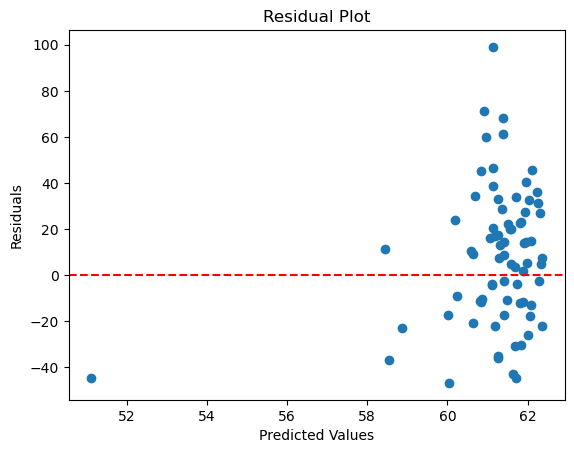

<Figure size 640x480 with 0 Axes>

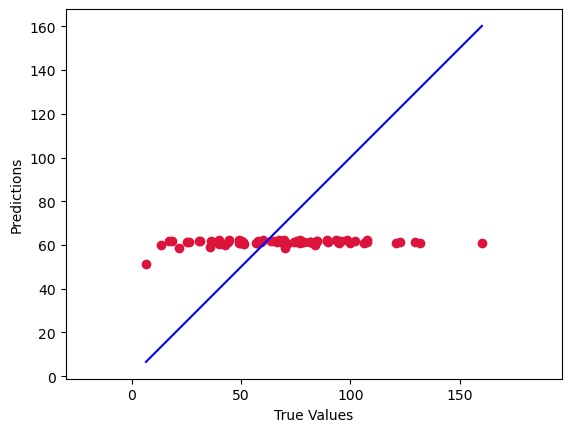

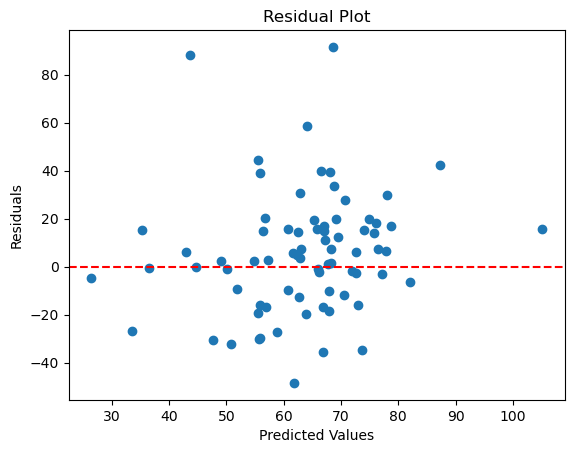

<Figure size 640x480 with 0 Axes>

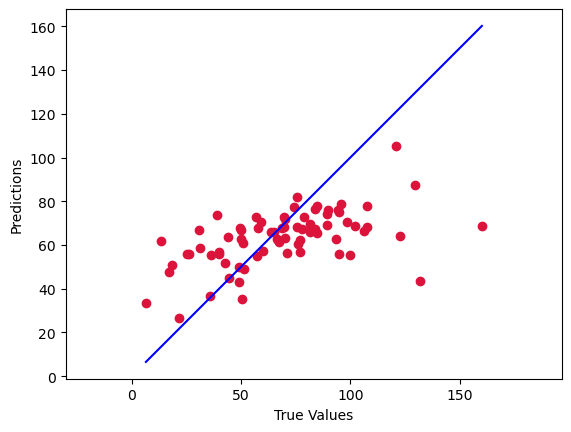

ElasticNet
MAE: 24.0473
RMSE: 30.1710
R2: -0.0260
SVR
MAE: 24.3891
RMSE: 30.4369
R2: -0.0441
Random Forest
MAE: 18.9008
RMSE: 25.8019
R2: 0.2497


In [10]:
errors = {name: train_evaluate_model(pipelines[name], x_train, y_train, x_test, y_test) for name in pipelines}
for name, metrics in errors.items():
    print(name)
    print(f"MAE: {metrics['MAE']:.4f}")
    print(f"RMSE: {metrics['RMSE']:.4f}")
    print(f"R2: {metrics['R2']:.4f}")

From these results, it is clear Random Forest has performed the best initially. 

### Clipping the outliers in the features
Looking at the other models, they had an $R^2 \approx 0$. In other words, the models currently aren't really performing better than simply guessing the mean.

As a follow-up, we can test several things. First, although RobustScaler helps with outliers, perhaps due to the heavy skew in some of the features, it is not enough. To test this, we can cap some of the outliers past a certain point. 

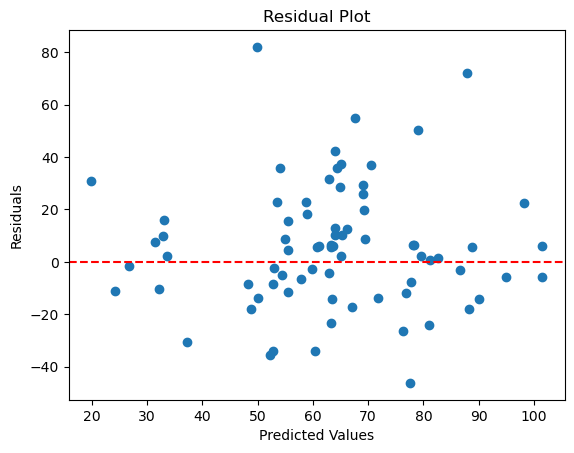

<Figure size 640x480 with 0 Axes>

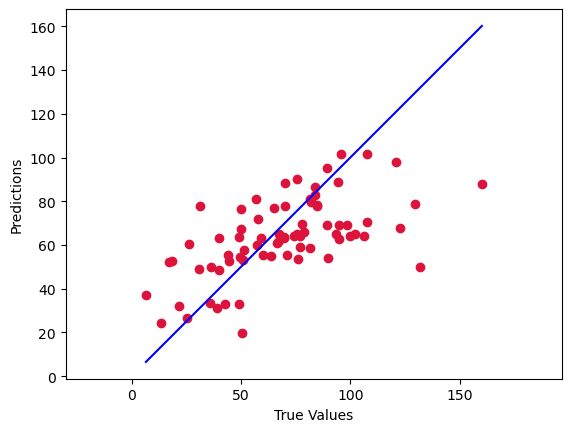

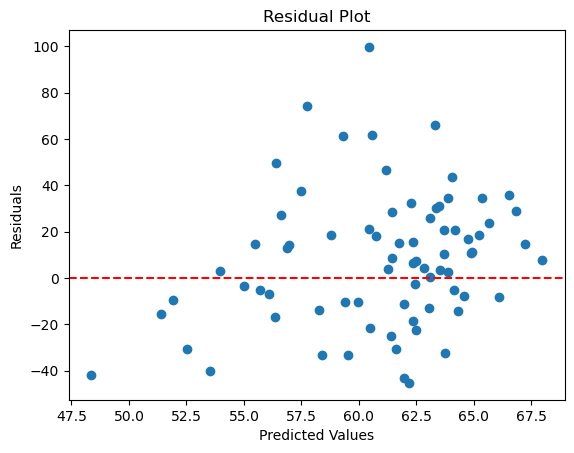

<Figure size 640x480 with 0 Axes>

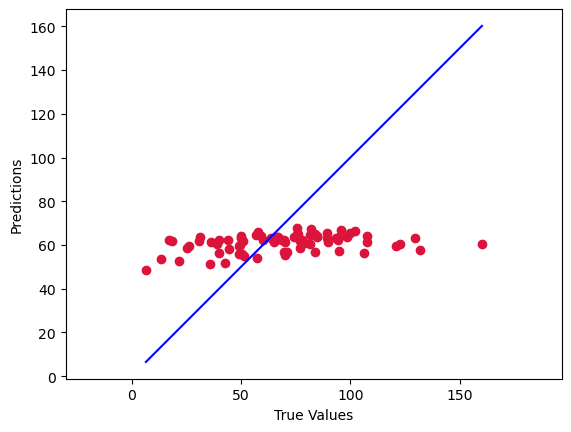

ElasticNet
MAE: 18.0018
RMSE: 24.2265
R2: 0.3385
SVR
MAE: 23.3134
RMSE: 29.7273
R2: 0.0040


In [11]:
from sklearn.base import BaseEstimator, TransformerMixin

# In order to incorporate clipping into the sklearn ingestion pipelines, it needs fit and transform methods.
# https://stackoverflow.com/a/31299784

class Clipper(BaseEstimator, TransformerMixin):
    def __init__(self, lower_pct = 5.0, upper_pct = 95.0):
        # Pct are percentiles denoting the outer edges
        self.lower_pct = lower_pct
        self.upper_pct = upper_pct
        self.a_ = None
        self.b_ = None
        
    def fit(self, x, y = None):
        # Compute the bounds based on percentiles here to ensure it's computed on training data only.
        self.a_ = np.percentile(x.values, self.lower_pct, axis = 0)
        self.b_ = np.percentile(x.values, self.upper_pct, axis = 0)
        return self
        
    def transform(self, x):
        return np.clip(x.values, self.a_, self.b_)

# Add in the clipper to the pipeline
# Omit Random Forest since that one isn't sensitive to data scaling. 
pipelines = {
    'ElasticNet': Pipeline(
    [
        ('clip', Clipper()), # Add the clipping first
        ('scaling', RobustScaler()),
        ('reduce_dim', PCA(n_components = 0.95)),
        ('model', ElasticNet(alpha=0.01, random_state=42))
    ]),
    'SVR': Pipeline(
    [
        ('clip', Clipper()),
        ('scaling', RobustScaler()),
        ('reduce_dim', PCA(n_components = 50)),
        ('model', SVR(kernel='rbf'))
    ]),
}

errors = {name: train_evaluate_model(pipelines[name], x_train, y_train, x_test, y_test) for name in pipelines}
for name, metrics in errors.items():
    print(name)
    print(f"MAE: {metrics['MAE']:.4f}")
    print(f"RMSE: {metrics['RMSE']:.4f}")
    print(f"R2: {metrics['R2']:.4f}")


### Grid Search
This significantly boosted the performance of ElasticNet. 

Surprisingly, none of our attempts have really changed the performance of SVR, which seems to constantly be predicting values around 40-80. Let's perform a small grid search to see if we can fix this.

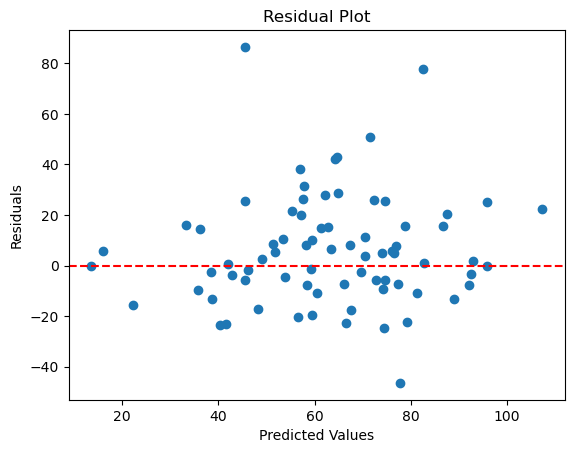

<Figure size 640x480 with 0 Axes>

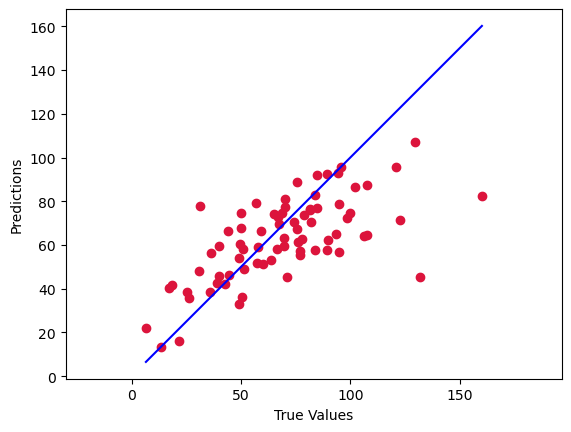

MAE: 16.3275
RMSE: 22.7175
R2: 0.4183


In [12]:
param_grid_svr = {
    'reduce_dim__n_components': [0.90, 0.95],  
    'model__C': [10, 100], # Regularization parameter
}

grid = GridSearchCV(
    pipelines['SVR'],
    param_grid_svr,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
    )

grid.fit(x_train, y_train)
# Use grid search model
model = grid.best_estimator_ 
errors = train_evaluate_model(model, x_train, y_train, x_test, y_test)

print(f"MAE: {errors['MAE']:.4f}")
print(f"RMSE: {errors['RMSE']:.4f}")
print(f"R2: {errors['R2']:.4f}")

These results look quite promising. The residual plots are showing relatively uniform residuals across the distribution of ground truth values while the scatterplot demonstrate the linear association developing between the predicions and the ground truth.
We do see some areas of weakness from our minor right skew where higher ground truth values didn't always receive a correspondingly high prediction. 

Finally, let's attempt to validate our results with K-Fold validation in a limited case. 

### K-Fold Cross-Validation
At this point, we have two pipelines that are performing well on the 9:1 split chosen at the start. Due to the small size of the testing dataset, it is imperative that we consider a K-Fold cross-validation step to better understand what kind of ranges we can expect in the performance of these models. 
Due to the limited computational resources, I will only do 10-fold cross-validation for the $R^2$ scores for our top two performing models, ElasticNet and SVR, the latter using the grid search optimized parameters above. 

In [13]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer

# Define the models to validate
pipelines = {
    'ElasticNet': Pipeline(
    [
        ('clip', Clipper()),
        ('scaling', RobustScaler()),
        ('reduce_dim', PCA(n_components = 50)),
        ('model', ElasticNet(alpha=0.01, random_state=42))
    ]),
    'SVR': Pipeline(
    [
        ('model', model)
    ]),
    'Random Forest': Pipeline(
    [
        ('model', RandomForestRegressor(random_state=42))
    ])
}

# Evaluate the R scores K Fold for K = 10
def evaluate_model(model, X, Y, cv=KFold(n_splits=10, shuffle=True, random_state=42)):
    scores = cross_val_score(model, X, Y, cv=cv, scoring=make_scorer(r2_score), n_jobs=-1)
    return (np.mean(scores), np.std(scores))

r2 = {}
for name in pipelines:
    r2[name]= evaluate_model(pipelines[name], X, Y)

By analyzing 10 folds, we confirm that of the pipelines tested, SVR is performing the best. In addition, we see that the previous results were inflated, with the largest inflation occurring in the ElasticNet model. Although each of the folds showed modest amounts of variation, the random forest results had the highest variance.

                   Mean  Standard Deviation
ElasticNet     0.108951            0.100546
SVR            0.270077            0.097466
Random Forest  0.188341            0.110442


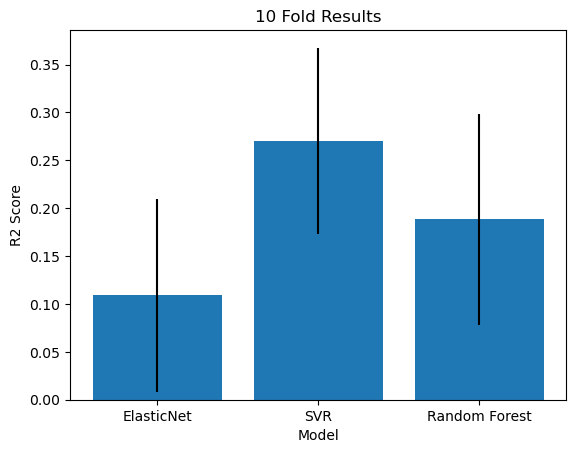

In [14]:
r2_table = pd.DataFrame(r2).T
r2_table.columns = ["Mean", "Standard Deviation"]
plt.bar(r2_table.index, r2_table["Mean"], yerr = r2_table["Standard Deviation"])
plt.title("10 Fold Results")
plt.xlabel("Model")
plt.ylabel("R2 Score")
print(r2_table)

## Conclusion

The best performing model is SVR. During an initial test using a single split of the dataset into training and testing, this model achieved a best performance with an MAE of approximately 16 and $R^2 \approx 0.42$. The latter means that approximately 42% of the permeability in the held out testing data was explained by the model. Given the initial results and the limited grid search, these modest results showed significant developments. 

When validating the models' performance using a 10-fold CV, we saw that SVR again performed the best. However, in all models tested, we saw that the $R^2$ scores calculated in the initial test was optimistic at best. Indeed, those scores dropped in all three models, though our best performing model SVR was the most robust to this decrease. 

The steep drop in performance from ElasticNet suggests that further regularization and possibly feature preprocessing should be explored. The higher variance in the random forest is along the same lines. Indeed, in the above analysis, I omitted ElasticNet and Random Forest from the grid search due to computational resource constraints. The smaller size of the dataset and the high potential of nonlinearity of the features suggested that SVR would have the highest potential, so it made sense to prioritize limited resources for this model.

### Future Works
Being an open ended problem, this experiment leaves much room for exploration and improvements. To aid me in deciding on a good endpoint, I used the instructions provided that the exercise should take approximately 2 hours. Since it was emphasized that project management will be a crucial component of this role, I strove to produce the best initial results while deferring many promising leads for future research, some of which I will discuss here. 

1. Due to constraints, I performed a very limited grid search on SVR only in the initial single split. This grid search optimized the performance for that particular split and yielded significant boosts in this case. Although the K Fold CV wasn't able to fully recapitulate the $R^2$ score, we still saw this model performing the best. In practice, we should perform a more extensive grid search as well as incorporate more models. Indeed, with the limited size of the dataset, we should incorporate K Fold from the beginning and perform nested fold CV when doing grid searches. However, this was prohibitively expensive with my compute resources. 
2. Expanding on the point briefly mentioned previously, we should consider additional models. I performed some very limited testing of a neural network architecture, where the initial results did not indicate enough potential to pursue the expensive task of exploring further. In addition, there are other models such as XGBoost that might be able to capture the nonlinear relationships in our data. 
3. The following [paper](https://arxiv.org/pdf/2310.14710) specifically addresses HDLSS problems in the context of classification. In this experiment, we don't quite have an HDLSS as the number of features (471) isn't quite as large as the number of samples (750). However, some of its ideas could potentially provide boosts to performance in our setup. In particular, we could try extracting co-occurrences in leaves between samples as the authors did to use in one of our regressors. 

Together, these results form a good baseline for this small dataset. In order to establish a robust model pipeline capable of handling sustained performance over time, there are several techniques we can employ. First, as new data are collected, we should track their effects in the ingestion pipelines. Recall that this consisted of a clipping step to cap the extreme values at 5% on both tails, followed by an application of RobustScaler, finished by PCA. We should verify that for new data, the feature distributions remain similar to the original dataset, which is crucial due to the multiple preprocessing steps. Ultimately, the influx of new data will require periodic retraining of the models. We can quantify this by measuring the drift in our performance metrics across time. The drift will probably be expedited by the fact that the initial training dataset was quite small. In effect, this could mean that subtle trends were not properly captured in our rather simplified models. This is already evident with the variability seen when performing K Fold CV. In general, we can expect that with more data, we can reduce the variability of the runs. With an expanded dataset, we could also potentially explore more advanced architecture. For example, random forests or deep learning models would benefit greatly from a larger sample size to feature dimension ratio. 